In [ ]:
import pandas as pd
import numpy as np
import torch
import pyro
import pyro.distributions as dist

from hmmlearn import hmm
from pgmpy.models import DiscreteBayesianNetwork
from pyro.distributions.hmm import DiscreteHMM
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

# Ad Data Preprocessing

In [3]:
# Define column renaming mapping (adjust if your CSV headers differ slightly)
rename_map = {
        'Device platform': 'Device_platform',
        'Platform': 'Platform',
        'Custom Audience Defined': 'Use_Custom_Audience',
        'Exclusion Defined': 'Use_Exclusions',
        'Amount spent': 'Amount_Spent',
        'CPM (cost per 1,000 impressions)': 'CPM',
        'Clicks (all)': 'Clicks',
        'Leads': 'Number_of_Leads',
        'Cost per Lead': 'CPL',
        'Objective': 'Campaign_Objective',
        'Headline_Local': 'Headline_Local',
        'Headline_Event': 'Headline_Event',
        'Headline_Exclusivity': 'Headline_Exclusivity',
        'Headline_Rental': 'Headline_Rental',
        'Headline_Returns': 'Headline_Returns',
        'Headline_Discounts': 'Headline_Discounts'
}

# Define all columns to keep based on rename_map keys + impressions/clicks
cols_to_keep_original = list(rename_map.keys()) + ['Month', 'Impressions', 'Reach', 'Frequency', 'Currency'] # Clicks is already in rename_map keys

df = pd.read_csv('./Data/data.csv')
# Select and rename
data = df[cols_to_keep_original].rename(columns=rename_map)

In [ ]:
#Calculate CTR

data['Clicks'].fillna(0)
data['Impressions'].fillna(0)
data['Clicks'] = data['Clicks'].astype(int)
data['Impressions'] = data['Impressions'].astype(int)
data['CTR'] = data['Clicks'] / data['Impressions']*100
data['CTR'] = data['CTR'].fillna(0)


#Convert Y/N to 1/0
cols_to_convert = ['Use_Custom_Audience', 'Use_Exclusions']
data[cols_to_convert] = data[cols_to_convert].replace({'Y': 1, 'N': 0})

# Set CPL to 100000 if lead count is 0
condition = (data['Number_of_Leads'] == 0) | pd.isna(data['Number_of_Leads'])
data['CPL'] = np.where(condition, 100000, data['Amount_Spent'] / data['Number_of_Leads'])

# Standardize amount to SGD
data['Amount_Spent'] = np.where(data['Currency'] == 'MYR', data['Amount_Spent'] * 0.3, data['Amount_Spent'])
#data.head

In [5]:
# 1. CPM (Percentiles)
# Let's use 10 bins (quintiles: 0-10%, 10-20%, 80-90%, 90-100%).

num_cpm_bins = 10
cpm_labels = [f'Quantile {i+1}' for i in range(num_cpm_bins)] # e.g., ['Quantile 1', 'Quantile 2', ...]
# Alternative descriptive labels:
# cpm_labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

data['CPM_Category'] = pd.qcut(data['CPM'],
                                q=num_cpm_bins,
                                labels=cpm_labels,
                                duplicates='drop') # Important if many values are the same
data['CPM_Category'] = data['CPM_Category'].cat.add_categories(['No spend'])
condition = (data['Amount_Spent'] == 0) | (data['Amount_Spent'].isna())
data.loc[condition, 'CPM_Category'] = 'No spend'

    
    
# 2. Amount Spent (Buckets of 100s)
# Bins: [0, 100), [100, 200), [200, 300), ...
max_spent = data['Amount_Spent'].max()
# Create bin edges from 0 up to slightly above the max, stepping by 100
amount_bins = np.arange(0, max_spent + 100, 100)
# Create labels like '0-100', '100-200', ...
amount_labels = [f'{int(amount_bins[i])}-{int(amount_bins[i+1])}' for i in range(len(amount_bins)-1)]
data['Amount_Spent_Category'] = pd.cut(data['Amount_Spent'],
                                       bins=amount_bins,
                                       labels=amount_labels,
                                       right=False,
                                       include_lowest=True)
data['Amount_Spent_Category'] = data['Amount_Spent_Category'].cat.add_categories(['No spend'])
condition = (data['Amount_Spent'] == 0) | (data['Amount_Spent'].isna())
data.loc[condition, 'Amount_Spent_Category'] = 'No spend'

print("Amount_Spent binned into 100s.")


# 3. CTR (Buckets of 1%)
# Bins: [0, 1), [1, 2), [2, 3), ...
max_ctr = data['CTR'].max()
ctr_bins = np.arange(0, max_ctr + 1, 1)
ctr_labels = [f'{int(ctr_bins[i])}%-{int(ctr_bins[i+1])}%' for i in range(len(ctr_bins)-1)]
data['CTR_Category'] = pd.cut(data['CTR'],
                              bins=ctr_bins,
                              labels=ctr_labels,
                              right=False,
                              include_lowest=True)
data['CTR_Category'] = data['CTR_Category'].cat.add_categories(['No clicks'])
data['CTR_Category'] = data['CTR_Category'].cat.add_categories(['Invalid CTR'])

condition = (data['CTR'] == 0) | (data['CTR'].isna() | (data['CTR'].isnull()) )
data.loc[condition, 'CTR_Category'] = 'No clicks'

data.loc[data['CTR'] > 1, 'CTR_Category'] = 'Invalid CTR' #There is one record with only 1 impression but 2 clicks. This is possible

print("CTR binned into 1% buckets.")


# 4. Number of Leads (Buckets of 5s)
# Bins: [0, 5), [5, 10), [10, 15), ... (Integers: 0-4, 5-9, 10-14, ...)
max_leads = data['Number_of_Leads'].max()
leads_bins = np.arange(0, max_leads + 5, 5)
leads_labels = [f'{int(leads_bins[i])}-{int(leads_bins[i+1])-1}' for i in range(len(leads_bins)-1)]
data['Leads_Category'] = pd.cut(data['Number_of_Leads'],
                                bins=leads_bins,
                                labels=leads_labels,
                                right=False,
                                include_lowest=True)
print("Number_of_Leads binned into buckets of 5.")


# 5. CPL (Buckets of $10)
# Bins: [0, 10), [10, 20), [20, 30), ...
cpl_nan_label = 'No_Leads'
max_cpl = data['CPL'].max()
cpl_bins = np.arange(0, max_cpl + 10, 10)
cpl_labels = [f'${int(cpl_bins[i])}-${int(cpl_bins[i+1])}' for i in range(len(cpl_bins)-1)]
data['CPL_Category'] = pd.cut(data['CPL'],
                              bins=cpl_bins,
                              labels=cpl_labels,
                              right=False,
                              include_lowest=True)
data['CPL_Category'] = data['CPL_Category'].cat.add_categories(['no leads'])
data.loc[data['Number_of_Leads'] == 0, 'CPL_Category'] = 'no leads'

print("CPL binned into $10 buckets.")

# --- Display Results ---
print("\nDataFrame with new category columns (first 5 rows):")
print(data[['CPM', 'CPM_Category', 'Amount_Spent', 'Amount_Spent_Category', 'CTR', 'CTR_Category', 'Number_of_Leads', 'Leads_Category', 'CPL', 'CPL_Category']].head())


Amount_Spent binned into 100s.
CTR binned into 1% buckets.
Number_of_Leads binned into buckets of 5.
CPL binned into $10 buckets.

DataFrame with new category columns (first 5 rows):
         CPM CPM_Category  Amount_Spent Amount_Spent_Category       CTR  \
0  17.028223   Quantile 1        900.91              900-1000  0.521670   
1  26.748129   Quantile 3        769.20               700-800  0.375559   
2  27.017320   Quantile 3       2125.48             2100-2200  1.069009   
3  11.897764   Quantile 1        626.92               600-700  0.442192   
4  13.273481   Quantile 1        413.23               400-500  1.683156   

  CTR_Category  Number_of_Leads Leads_Category        CPL CPL_Category  
0        0%-1%               56          55-59  16.087679      $10-$20  
1        0%-1%               34          30-34  75.411765      $70-$80  
2  Invalid CTR               32          30-34  66.421250      $60-$70  
3        0%-1%               32          30-34  19.591250      $10-$20  
4

In [6]:
data

,Device_platform,Platform,Use_Custom_Audience,Use_Exclusions,Amount_Spent,CPM,Clicks,Number_of_Leads,CPL,Campaign_Objective,...,Impressions,Reach,Frequency,Currency,CTR,CPM_Category,Amount_Spent_Category,CTR_Category,Leads_Category,CPL_Category
0,mobile_app,instagram,1,0,900.91,17.028223,276,56,16.087679,OUTCOME_LEADS,...,52907,24856.0,2.128540,SGD,0.521670,Quantile 1,900-1000,0%-1%,55-59,$10-$20
1,mobile_app,instagram,0,0,769.20,26.748129,360,34,75.411765,OUTCOME_LEADS,...,95857,36698.0,2.612050,MYR,0.375559,Quantile 3,700-800,0%-1%,30-34,$70-$80
2,mobile_app,facebook,1,1,2125.48,27.017320,841,32,66.421250,OUTCOME_LEADS,...,78671,34312.0,2.292813,SGD,1.069009,Quantile 3,2100-2200,Invalid CTR,30-34,$60-$70
3,mobile_app,instagram,0,0,626.92,11.897764,233,32,19.591250,OUTCOME_LEADS,...,52692,24121.0,2.184487,SGD,0.442192,Quantile 1,600-700,0%-1%,30-34,$10-$20
4,mobile_app,facebook,0,0,413.23,13.273481,524,31,13.330000,OUTCOME_LEADS,...,31132,15056.0,2.067747,SGD,1.683156,Quantile 1,400-500,Invalid CTR,30-34,$10-$20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9743,mobile_app,facebook,0,1,2.97,60.612245,1,0,100000.000000,OUTCOME_LEADS,...,49,48.0,1.020833,SGD,2.040816,Quantile 7,0-100,Invalid CTR,0-4,no leads
9744,mobile_app,instagram,0,1,3.22,89.444444,2,0,100000.000000,OUTCOME_LEADS,...,36,28.0,1.285714,SGD,5.555556,Quantile 8,0-100,Invalid CTR,0-4,no leads
9745,mobile_app,facebook,0,1,7.08,51.304348,7,0,100000.000000,OUTCOME_LEADS,...,138,109.0,1.266055,SGD,5.072464,Quantile 6,0-100,Invalid CTR,0-4,no leads
9746,mobile_app,instagram,0,1,0.49,61.250000,0,0,100000.000000,OUTCOME_LEADS,...,8,8.0,1.000000,SGD,0.000000,Quantile 7,0-100,No clicks,0-4,no leads


# HMM

Goal: Capture seasonality between months as a latent variable

Season_t   → Season_{t+1} \
Season_t   → Impressions_t \
Platform_t → Impressions_t \
Impressions_{t} → Impressions_{t+1} \
Month_t    → (observed input into Season_t or child of Season)

Model monthly impressions (counts) as arising from a latent seasonal regime that evolves over time via a Hidden Markov Model (HMM). Because impressions are non‐negative integer counts, a Poisson emission should capture their variance–mean relationship. We aggregate per‐platform monthly counts into separate time-series segments, fit a Poisson-HMM across all platforms (using sequence‐length information to respect platform boundaries), and select the number of latent seasons via the Bayesian Information Criterion (BIC). The resulting Viterbi states provide a point estimate of seasonality; the posterior probabilities give soft, probabilistic assignments to seasonal regimes.

In [7]:
hmm_df = data.copy()

In [8]:
# Converting month: E.g. 2023-03
hmm_df["Month"] = pd.to_datetime(hmm_df["Month"].str[:10]).dt.to_period("M")          
hmm_df.sort_values("Month", inplace=True)

# For each distinct (Month, Platform) pair, sum up all the raw Impressions - one time series per Platform
monthly_impressions = (hmm_df.groupby(["Month", "Platform"], as_index=False)["Impressions"].sum().sort_values(["Platform", "Month"]))

In [9]:
monthly_impressions

,Month,Platform,Impressions
0,2023-03,audience_network,36
8,2023-05,audience_network,19009
13,2023-06,audience_network,28
32,2024-01,audience_network,1
45,2024-07,audience_network,62260
...,...,...,...
12,2023-05,unknown,91
17,2023-06,unknown,323
20,2023-07,unknown,217
23,2023-08,unknown,59


In [10]:
# one per Platform, each shaped (T_i, 1) for that platform’s T_i months of data
seqs      = []
seq_lens  = []
for _ , g in monthly_impressions.groupby("Platform"):
    seqs.append(g["Impressions"].astype(int).values.reshape(-1, 1))
    seq_lens.append(len(g))
X  = np.concatenate(seqs, axis=0) # shape: (total_months_across_all_platforms, 1)
seq_lens = [len(s) for s in seqs]

In [11]:
# BIC to pick states
best_bic = np.inf  
results = []
k = 5 # Number of states to represent seasonality for each platform

model = hmm.PoissonHMM(n_components=k, n_iter=200, tol=1e-4, random_state=777)
model.fit(X, lengths=seq_lens)
ll = model.score(X, lengths=seq_lens)
bic = -2*ll + k * np.log(len(X))
if bic < best_bic:
    best_bic, best_model = bic, model

# Decode
post = best_model.predict_proba(X, lengths=seq_lens)
states = best_model.predict(X, lengths=seq_lens)

In [12]:
monthly_impressions["Seasonality"] = states
hmm_df = (hmm_df.merge(monthly_impressions[["Month","Platform","Seasonality"]], on=["Month","Platform"], how="left"))

### Improvements that can be made here

- Impressions currently should not be distributed as a Poisson distribution. 
- Use a negative binomial distribution instead since Variance of impressions > mean, a sign of overdispersion
- Can seperate the data further into different platforms and use a different model for each platform (Not covered in the following code)

In [13]:
stats = (
    monthly_impressions
      .groupby("Platform")["Impressions"]
      .agg(mean="mean", var="var", n="size")
      .assign(var_mean_ratio=lambda d: d["var"] / d["mean"])
)

print(stats.round(2))

                       mean           var   n  var_mean_ratio
Platform                                                     
audience_network   17864.83  5.982438e+08   6        33487.23
facebook          576796.76  1.931484e+11  25       334863.96
instagram         367149.52  8.498512e+10  25       231472.78
messenger           3541.67  3.752403e+07   3        10595.02
unknown              123.00  1.414100e+04   7          114.97


In [14]:
hmm_df = data.copy()
hmm_df["Month"] = pd.to_datetime(hmm_df["Month"].str[:10]).dt.to_period("M")
monthly_impressions = (hmm_df.groupby(["Month","Platform"], as_index=False)["Impressions"]
               .sum().sort_values(["Platform","Month"]))

In [15]:
seqs, seq_lens = [], []
for _, g in monthly_impressions.groupby("Platform"):
    seqs.append(torch.tensor(g["Impressions"].values.astype(float),
                             dtype=torch.float32))
    seq_lens.append(len(g))

device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X        = torch.cat(seqs).to(device)
seq_lens = torch.tensor(seq_lens, dtype=torch.long, device=device)

In [16]:
K = 5  # number of seasonal states

def model(data, lengths):
    # Initialization
    # init_logits spread across quantiles
    qs = np.quantile(X.cpu().numpy(), np.linspace(0.1,0.9,K))
    init_vals = torch.log(torch.tensor(qs, device=device) + 1e-3)
    init_noise= 0.1 * torch.randn(K, device=device)
    init_logits = pyro.param("init_logits",
                             init_vals + init_noise)

    # Sticky self-transitions: identity*K + jitter
    base_T = torch.eye(K, device=device) * 3.0    # 3 = self-bias
    jitter = 0.01 * torch.randn(K, K, device=device)
    trans_logits = pyro.param("trans_logits",
                              base_T + jitter)

    # Negative-Binom emission parameters seeded by data quantiles
    qs2       = np.percentile(X.cpu().numpy(), np.linspace(5,95,K))
    nb_logits = pyro.param("nb_logits",
                           torch.log(torch.tensor(qs2+1e-3,
                                                  device=device)))
    nb_r      = pyro.param("nb_r",
                           torch.linspace(1.0,5.0,K, device=device),
                           constraint=dist.constraints.positive)

    emission = dist.NegativeBinomial(total_count=nb_r,
                                     logits=nb_logits)

    hmm = DiscreteHMM(initial_logits   = init_logits,
                      transition_logits= trans_logits,
                      observation_dist = emission)

    # Accumulate per-platform log-likelihoods
    offset, total_lp = 0, 0.0
    for L in lengths.tolist():
        seq = data[offset:offset+L]
        total_lp = total_lp + hmm.log_prob(seq)
        offset += L

    pyro.factor("hmm_segments", total_lp)
    return total_lp

In [17]:
# SVI Fitting with random seed
def fit_hmm(seed):
    pyro.clear_param_store()
    pyro.set_rng_seed(seed)

    guide = pyro.infer.autoguide.AutoNormal(model)
    svi   = SVI(model, guide, Adam({"lr":0.02}), loss=Trace_ELBO())

    for _ in range(500):
        svi.step(X, lengths=seq_lens)
    return svi.evaluate_loss(X, lengths=seq_lens)

best_nll, best_seed = float("inf"), None
seed = 85 # Already performed range(n) to find best seed
nll = fit_hmm(seed)

In [18]:
# Viterbi decoding
# retrieve final parameters
init_logits  = pyro.param("init_logits")
trans_logits = pyro.param("trans_logits")
nb_logits    = pyro.param("nb_logits")
nb_r         = pyro.param("nb_r")

log_init  = init_logits - torch.logsumexp(init_logits, dim=0)
log_trans = trans_logits - torch.logsumexp(trans_logits,
                                            dim=1, keepdim=True)
nb_dist   = torch.distributions.NegativeBinomial(total_count=nb_r,
                                                 logits=nb_logits)

def viterbi_path(obs):
    T = obs.size(0)
    B = nb_dist.log_prob(obs.unsqueeze(-1))  # (T, K)
    Sigma = torch.empty(T, K, device=device)
    Phi = torch.empty(T, K, dtype=torch.long, device=device)

    Sigma[0] = log_init + B[0]
    for t in range(1, T):
        scores = Sigma[t-1].unsqueeze(1) + log_trans
        Sigma[t], Phi[t] = scores.max(0)
        Sigma[t] += B[t]

    path = torch.empty(T, dtype=torch.long, device=device)
    path[-1] = Sigma[-1].argmax()
    for t in range(T-2, -1, -1):
        path[t] = Phi[t+1, path[t+1]]
    return path.cpu().numpy()

states, off = [], 0
for L in seq_lens.tolist():
    states.append(viterbi_path(X[off:off+L]))
    off += L

monthly_impressions["Seasonality"] = np.concatenate(states)
data = (hmm_df.merge(monthly_impressions[["Month","Platform","Seasonality"]],on=["Month","Platform"], how="left"))

In [19]:
data

,Device_platform,Platform,Use_Custom_Audience,Use_Exclusions,Amount_Spent,CPM,Clicks,Number_of_Leads,CPL,Campaign_Objective,...,Reach,Frequency,Currency,CTR,CPM_Category,Amount_Spent_Category,CTR_Category,Leads_Category,CPL_Category,Seasonality
0,mobile_app,instagram,1,0,900.91,17.028223,276,56,16.087679,OUTCOME_LEADS,...,24856.0,2.128540,SGD,0.521670,Quantile 1,900-1000,0%-1%,55-59,$10-$20,3
1,mobile_app,instagram,0,0,769.20,26.748129,360,34,75.411765,OUTCOME_LEADS,...,36698.0,2.612050,MYR,0.375559,Quantile 3,700-800,0%-1%,30-34,$70-$80,2
2,mobile_app,facebook,1,1,2125.48,27.017320,841,32,66.421250,OUTCOME_LEADS,...,34312.0,2.292813,SGD,1.069009,Quantile 3,2100-2200,Invalid CTR,30-34,$60-$70,4
3,mobile_app,instagram,0,0,626.92,11.897764,233,32,19.591250,OUTCOME_LEADS,...,24121.0,2.184487,SGD,0.442192,Quantile 1,600-700,0%-1%,30-34,$10-$20,3
4,mobile_app,facebook,0,0,413.23,13.273481,524,31,13.330000,OUTCOME_LEADS,...,15056.0,2.067747,SGD,1.683156,Quantile 1,400-500,Invalid CTR,30-34,$10-$20,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9743,mobile_app,facebook,0,1,2.97,60.612245,1,0,100000.000000,OUTCOME_LEADS,...,48.0,1.020833,SGD,2.040816,Quantile 7,0-100,Invalid CTR,0-4,no leads,4
9744,mobile_app,instagram,0,1,3.22,89.444444,2,0,100000.000000,OUTCOME_LEADS,...,28.0,1.285714,SGD,5.555556,Quantile 8,0-100,Invalid CTR,0-4,no leads,3
9745,mobile_app,facebook,0,1,7.08,51.304348,7,0,100000.000000,OUTCOME_LEADS,...,109.0,1.266055,SGD,5.072464,Quantile 6,0-100,Invalid CTR,0-4,no leads,4
9746,mobile_app,instagram,0,1,0.49,61.250000,0,0,100000.000000,OUTCOME_LEADS,...,8.0,1.000000,SGD,0.000000,Quantile 7,0-100,No clicks,0-4,no leads,3


# Sensortower Data Preprocessing

In [20]:
import pandas as pd

# Load and preprocess data
df_android = pd.read_csv('./Data/Sensor_Tower_App_Performance_Demographics_2024-10-01_to_2024-12-31_android.csv', sep='\t', encoding='utf-16')
df_ios = pd.read_csv('./Data/Sensor_Tower_App_Performance_Demographics_2024-10-01_to_2024-12-31_ios.csv', sep='\t', encoding='utf-16')

df_android['OS'] = 'android'
df_ios['OS'] = 'ios'

# Combine both DataFrames
df_combined = pd.concat([df_android, df_ios])

# List of gender-age columns
gender_age_cols = [col for col in df_combined.columns 
                  if ('Female' in col or 'Male' in col) 
                  and any(age in col for age in ['18-24', '25-34', '35-44', '45-54', '55-99'])]

# Convert percentage strings to numeric values
for col in gender_age_cols:
    df_combined[col] = df_combined[col].str.rstrip('%').astype('float') / 100.0

# Calculate total users (sum of all percentages)
total_users = df_combined[gender_age_cols].sum().sum()

# Gender probabilities
genders = ['Female', 'Male']
gender_prob = {
    gender: df_combined[[col for col in gender_age_cols if col.startswith(gender)]].sum().sum() / total_users
    for gender in genders
}

# Age group probabilities (regardless of gender)
age_groups = ['18-24', '25-34', '35-44', '45-54', '55-99']
age_prob = {
    age: df_combined[[col for col in gender_age_cols if age in col]].sum().sum() / total_users
    for age in age_groups
}

# Gender probabilities within each age group
gender_age_conditional_prob = {
    f"{gender}_{age}": df_combined[f"{gender} {age}"].sum() / df_combined[[f"Female {age}", f"Male {age}"]].sum().sum()
    for gender in genders
    for age in age_groups
}

def reformat_gender_age_conditional(original_dict):
    gender_age_conditional = {}
    
    for key, value in original_dict.items():
        # Split key into Gender and Age
        gender, age = key.split('_')
        
        # Initialize gender if not already in the dictionary
        if gender not in gender_age_conditional:
            gender_age_conditional[gender] = {}
        
        # Assign the probability to the nested structure
        gender_age_conditional[gender][age] = float(value)  # Convert np.float64 to Python float
    
    return gender_age_conditional

gender_prob = {key: float(value) for key, value in gender_prob.items()}
age_prob = {key: float(value) for key, value in age_prob.items()}
gender_age_conditional_prob = reformat_gender_age_conditional(gender_age_conditional_prob)

print("Gender Probabilities:")
print(gender_prob)
print("\nAge Group Probabilities:")
print(age_prob)
print("\nGender Probabilities within Age Groups:")
print(gender_age_conditional_prob)

Gender Probabilities:
{'Female': 0.39509999999999995, 'Male': 0.6048999999999999}

Age Group Probabilities:
{'18-24': 0.3395142857142857, '25-34': 0.3842142857142857, '35-44': 0.18322857142857144, '45-54': 0.07251428571428573, '55-99': 0.020528571428571427}

Gender Probabilities within Age Groups:
{'Female': {'18-24': 0.4028023226457965, '25-34': 0.39367912251347836, '35-44': 0.38476532044285044, '45-54': 0.3926319936958234, '55-99': 0.39526791927627003}, 'Male': {'18-24': 0.5971976773542035, '25-34': 0.6063208774865216, '35-44': 0.6152346795571496, '45-54': 0.6073680063041765, '55-99': 0.60473208072373}}


# DAG

In [21]:
amt_spent_cat = 'Amount_Spent_Category'
amt_spent = 'Amount_Spent'
cpm = 'CPM_Category'
ctr = 'CTR_Category'
leads = 'Leads_Category' # Corresponds to N
cpl = 'CPL_Category'     # Corresponds to L
device = 'Device_platform' # Corresponds to DP
platform = 'Platform'     # Corresponds to PL
custom_aud = 'Use_Custom_Audience' # Corresponds to CA
exclusions = 'Use_Exclusions'     # Corresponds to EX
objective = 'Campaign_Objective' # Corresponds to CO
hl = 'Headline_Local'
he = 'Headline_Event'
hx = 'Headline_Exclusivity'
hr = 'Headline_Rental'
hrt = 'Headline_Returns' # Assuming maps to HRT
hd = 'Headline_Discounts'
reach = 'Reach'
frequency = 'Frequency'
impressions = 'Impressions'
gender = 'Gender'
age = 'Age'

# List of all nodes expected in the model_data DataFrame
all_nodes = [
    amt_spent, amt_spent_cat, cpm, ctr, leads, cpl, device, platform, custom_aud,
    exclusions, objective, hl, he, hx, hr, hrt, hd, reach, frequency, impressions, gender, age
]


# Elements that can be controlled
headlines = [hl, he, hx, hr, hrt, hd]
settings_context_nodes = [amt_spent_cat, device, platform, custom_aud, exclusions, objective]
all_settings_nodes = list(set(settings_context_nodes + headlines)) # Use set to ensure unique
latent_nodes = [gender, age]

In [22]:
model = DiscreteBayesianNetwork()

print(f"Checking/Adding nodes: {all_nodes}")

# Optional: Check against data columns first
missing_nodes = [node for node in all_nodes if node not in data.columns and node not in latent_nodes]
if missing_nodes:
    print(f"ERROR: Nodes missing from data columns: {missing_nodes}")
    present_nodes = [node for node in all_nodes if node in data.columns or node in latent_nodes]
    print(f"Warning: Adding only nodes present in data or latent nodes: {present_nodes}")
    model.add_nodes_from(present_nodes)
else:
    print("All nodes found. Adding all nodes.")
    model.add_nodes_from(all_nodes)

# Update: Get model nodes after they are added
present_model_nodes = list(model.nodes())

# Define edges (Parent -> Child relationships) based on plausible influence flow
edges = []

# Function to safely add edge if both nodes exist in the model
def add_safe_edge(parent, child):
    if parent in model.nodes() and child in model.nodes() and parent != child:
        edges.append((parent, child))

# Define edges as grouped relationships
parent_child = [
    [[amt_spent], [amt_spent_cat]],  # Amount Spent -> Amount Spent Category
    [[device, platform], latent_nodes],  # Device + Platform -> Gender + Age
    [settings_context_nodes + latent_nodes, [cpm]],  # Settings + Gender + Age -> CPM
    [latent_nodes + [objective], [reach]],  # Gender + Age + Objective -> Reach
    [[amt_spent, cpm, objective], [impressions]],  # Amount Spent + CPM + Objective -> Impressions
    [[impressions, reach, objective], [frequency]],  # Impressions + Reach + Objective -> Frequency
    [settings_context_nodes + headlines + [frequency], [ctr]],  # Settings + Headlines + Frequency -> CTR
    [[impressions, ctr], [leads]],  # Impressions + CTR -> Leads
    [[amt_spent_cat, leads], [cpl]],  # Amount Spent Category + Leads -> CPL
]

# Function to add all valid edges
def add_edges(parent_child):
    for parent_list, child_list in parent_child:
        for parent in parent_list:
            for child in child_list:
                add_safe_edge(parent, child)

# Add the edges
add_edges(parent_child)

# Print edges being added for verification
print(f"Edges being added: {edges}")

# Add all edges to the model
model.add_edges_from(edges)

Checking/Adding nodes: ['Amount_Spent', 'Amount_Spent_Category', 'CPM_Category', 'CTR_Category', 'Leads_Category', 'CPL_Category', 'Device_platform', 'Platform', 'Use_Custom_Audience', 'Use_Exclusions', 'Campaign_Objective', 'Headline_Local', 'Headline_Event', 'Headline_Exclusivity', 'Headline_Rental', 'Headline_Returns', 'Headline_Discounts', 'Reach', 'Frequency', 'Impressions', 'Gender', 'Age']
All nodes found. Adding all nodes.
Edges being added: [('Amount_Spent', 'Amount_Spent_Category'), ('Device_platform', 'Gender'), ('Device_platform', 'Age'), ('Platform', 'Gender'), ('Platform', 'Age'), ('Amount_Spent_Category', 'CPM_Category'), ('Device_platform', 'CPM_Category'), ('Platform', 'CPM_Category'), ('Use_Custom_Audience', 'CPM_Category'), ('Use_Exclusions', 'CPM_Category'), ('Campaign_Objective', 'CPM_Category'), ('Gender', 'CPM_Category'), ('Age', 'CPM_Category'), ('Gender', 'Reach'), ('Age', 'Reach'), ('Campaign_Objective', 'Reach'), ('Amount_Spent', 'Impressions'), ('CPM_Categor

### Imputing the latents (Age, Gender)

1. For each row, we use the following data as priors from Sensortower:

$$
P(G=g) \;=\;\pi_g,
\quad
P(A=a) \;=\;\alpha_a,
\quad
P(A=a \mid G=g) \;=\;\tau_{g,a}.
$$


2. and compute the unnormalized joint for each row 𝑖, with the simplified conditionals based on our DAG:


$$
\tilde P_i(g,a)
\;=\;
P(G=g\mid dp_i,pl_i)\,\times\,P(A=a\mid dp_i,pl_i)\,\times\,P(A=a\mid G=g)
\;\times\;
P\bigl(\mathrm{CPM}_i \mid g,a,\dots\bigr)
\;\times\;
\mathcal{N}\bigl(r_i\mid \mu_{g,a,c_i},\,\sigma_{g,a,c_i}\bigr).
$$


3. The evidence, total probability of the observed data under all (g, a):

$$
e_i
\;=\;
\sum_{g\,\in\,\mathcal G}\,\sum_{a\,\in\,\mathcal A}
\tilde P_i(g,a).
$$

4. The normalized responsibilities (E-step outputs):

$$
P(G=g,\,A=a\mid \mathrm{obs}_i)
\;=\;
\frac{\tilde P_i(g,a)}{\,e_i\,}.
$$

5. The EM objective (to track convergence). In this case we use Negative Log-Likelihood:

$$
\mathcal L
\;=\;
-\sum_{i=1}^{N}\ln\bigl(e_i\bigr).
$$

6. M-step (Gender) - weighted counts under each parent‐configuration 𝑝𝑘 and Laplace-smoothed probabilities:

$$
N_{pk}(g)
\;=\;
\sum_{i=1}^N \sum_{a\in\mathcal A}
P(G=g,A=a\mid \mathrm{obs}_i),
\quad
P(G=g\mid pk)
\;=\;
\frac{\,N_{pk}(g)+1\,}
     {\,\sum_{g'}\bigl(N_{pk}(g')+1\bigr)\,}.
$$

7. M-step (Age):

$$
N_{pk}(a)
\;=\;
\sum_{i=1}^N \sum_{g\in\mathcal G}
P(G=g,A=a\mid \mathrm{obs}_i),
\quad
P(A=a\mid pk)
\;=\;
\frac{\,N_{pk}(a)+1\,}
     {\,\sum_{a'}\bigl(N_{pk}(a')+1\bigr)\,}.
$$

8. M-step (CPM_Category), weighted counts for each CPM category value 𝑣:

$$
N_{pk}(v)
\;=\;
\sum_{i:\,\mathrm{CPM}_i\;\text{observed}}
\sum_{(g,a)}\mathbf1\{v_i=v\}\,P(G=g,A=a\mid \mathrm{obs}_i),
\quad
P(v\mid pk)
\;=\;
\frac{\,N_{pk}(v)+1\,}
     {\,\sum_{v'}\bigl(N_{pk}(v')+1\bigr)\,}.
$$

9. M-step (Reach), the weighted mean and variance for each k:

$$
W_k   = \sum_{i}\sum_{g,a} w_{i,(g,a)},
\quad
WX_k  = \sum_{i}\sum_{g,a} w_{i,(g,a)}\,r_i,
\quad
WX2_k = \sum_{i}\sum_{g,a} w_{i,(g,a)}\,r_i^2,
$$
$$
\mu_k = \frac{WX_k}{W_k},
\quad
\sigma_k = \max\!\Bigl(\sqrt{\max\{WX2_k/W_k - \mu_k^2,\,0\}},\,10^{-2}\Bigr).
$$

10. MAP Imputation, the most probable assignments for each row under the current posterior:

$$
\hat g_i
=\arg\max_{g}\sum_{a}P(G=g,A=a\mid \mathrm{obs}_i),
\quad
\hat a_i
=\arg\max_{a}\sum_{g}P(G=g,A=a\mid \mathrm{obs}_i).
$$

11. Convergence Criteria (we chose tol == 0.05%):

$$
\Delta\% 
= 
\frac{\mathcal L_{t-1} - \mathcal L_{t}}{\lvert\mathcal L_{t-1}\rvert}\times100\%.
$$

$$
\frac{1}{N}\sum_i\mathbf1[\hat G_i^{(t)}\neq \hat G_i^{(t-1)}] < \text{tol},
\quad
\frac{1}{N}\sum_i\mathbf1[\hat A_i^{(t)}\neq \hat A_i^{(t-1)}] < \text{tol}.
$$


Nodes in subgraph: {'Campaign_Objective', 'Gender', 'Reach', 'Device_platform', 'Amount_Spent_Category', 'Use_Custom_Audience', 'Use_Exclusions', 'Platform', 'Age', 'CPM_Category'}


C:\Users\typed\AppData\Local\Temp\ipykernel_12520\2608692139.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


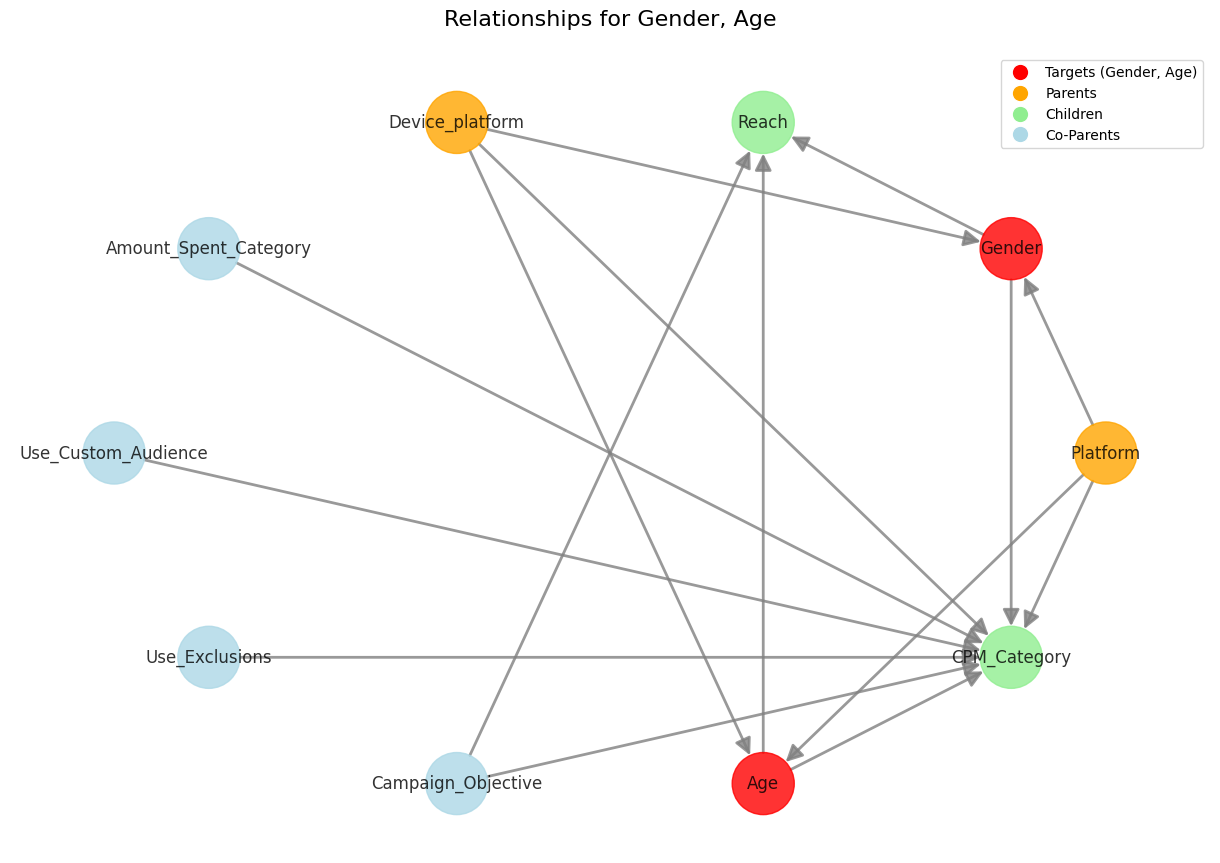

In [23]:
import networkx as nx
import matplotlib.pyplot as plt

target_nodes = ["Gender", "Age"]  # Target nodes

# Check if target nodes exist
for target_node in target_nodes:
    if target_node not in model.nodes():
        print(f"Error: '{target_node}' not found. Available nodes: {list(model.nodes())}")
        exit()

# Create subgraph for all target nodes
relevant_nodes = set(target_nodes)
for target_node in target_nodes:
    relevant_nodes.update(model.predecessors(target_node))  # Parents
    relevant_nodes.update(model.successors(target_node))    # Children

    # Add co-parents
    for child in model.successors(target_node):
        relevant_nodes.update(model.predecessors(child))

print("Nodes in subgraph:", relevant_nodes)

if len(relevant_nodes) == 0:
    print(f"No connections found for '{target_nodes}'")
else:
    plt.figure(figsize=(12, 8))
    subgraph = model.subgraph(relevant_nodes)
    
    try:
        pos = nx.kamada_kawai_layout(subgraph)
    except:
        pos = nx.shell_layout(subgraph)
    
    node_colors = []
    for node in subgraph.nodes():
        if node in target_nodes:
            node_colors.append("red")
        elif node in model.predecessors(target_nodes[0]) or node in model.predecessors(target_nodes[1]):
            node_colors.append("orange")
        elif node in model.successors(target_nodes[0]) or node in model.successors(target_nodes[1]):
            node_colors.append("lightgreen")
        else:
            node_colors.append("lightblue")
    
    nx.draw(
        subgraph, pos,
        with_labels=True,
        node_color=node_colors,
        node_size=2000,
        font_size=12,
        arrowsize=25,
        edge_color="gray",
        width=2.0,
        alpha=0.8
    )
    
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label=f'Targets ({", ".join(target_nodes)})', markerfacecolor='red', markersize=12),
        Line2D([0], [0], marker='o', color='w', label='Parents', markerfacecolor='orange', markersize=12),
        Line2D([0], [0], marker='o', color='w', label='Children', markerfacecolor='lightgreen', markersize=12),
        Line2D([0], [0], marker='o', color='w', label='Co-Parents', markerfacecolor='lightblue', markersize=12)
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.title(f"Relationships for {', '.join(target_nodes)}", fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()


In [24]:
subgraph.edges

OutEdgeView([('Platform', 'Gender'), ('Platform', 'Age'), ('Platform', 'CPM_Category'), ('Gender', 'CPM_Category'), ('Gender', 'Reach'), ('Device_platform', 'Gender'), ('Device_platform', 'Age'), ('Device_platform', 'CPM_Category'), ('Amount_Spent_Category', 'CPM_Category'), ('Use_Custom_Audience', 'CPM_Category'), ('Use_Exclusions', 'CPM_Category'), ('Campaign_Objective', 'CPM_Category'), ('Campaign_Objective', 'Reach'), ('Age', 'CPM_Category'), ('Age', 'Reach')])

In [25]:
import pandas as pd
import numpy as np
import copy
from collections import defaultdict
from scipy.stats import norm

class BayesianImputer:
    def __init__(self, data, gender_probs, age_probs, gender_age_conditional,
                 verbose=False):
        self.data = data.copy()
        self.gender_levels = list(gender_probs.keys())
        self.age_levels    = list(age_probs.keys())

        # Priors
        self.prior_gender = gender_probs
        self.prior_age    = age_probs
        self.gender_age_conditional = gender_age_conditional

        # Storage for discrete
        self.cpts = self._initialize_cpts()
        # Storage for Reach Gaussian params
        self.reach_params = {}   # key=(g,a,campaign) → (mu, sigma)

        self.verbose = verbose
        self.history = []

    def _initialize_cpts(self):
        return {
            'Gender':      {'parents': ['Device_platform','Platform'],
                            'probs': defaultdict(dict)},
            'Age':         {'parents': ['Device_platform','Platform'],
                            'probs': defaultdict(dict)},
            'CPM_Category':{'parents': ['Gender','Age',
                                        'Amount_Spent_Category',
                                        'Use_Exclusions',
                                        'Campaign_Objective',
                                        'Use_Custom_Audience'],
                            'probs': defaultdict(dict)}
        }

    def _estimate_cpt(self, child, parents, levels):
        """Discrete CPT estimate with Laplace smoothing."""
        if child not in self.data.columns:
            return
        df = self.data[parents + [child]].dropna()
        if df.empty:
            return

        counts = df.groupby(parents + [child]).size().unstack(fill_value=0)
        counts = counts.reindex(columns=levels, fill_value=0)
        smoothed = counts + 1
        probs    = smoothed.div(smoothed.sum(axis=1), axis=0)

        cpt = self.cpts[child]['probs']
        for parent_vals, row in probs.iterrows():
            key = parent_vals if isinstance(parent_vals, tuple) else (parent_vals,)
            cpt[key] = row.to_dict()

    def e_step(self):
        """E-step: compute posteriors and per-row evidence."""
        posteriors = []
        evidences  = []

        # we only have one discrete child besides Reach
        children = ['CPM_Category']

        for idx, row in self.data.iterrows():
            dp, pl = row.get('Device_platform'), row.get('Platform')
            joint = {}

            for g in self.gender_levels:
                for a in self.age_levels:
                    # prior = P(G|dp,pl) * P(A|dp,pl) * P(A|G)
                    p_g = self.cpts['Gender']['probs']\
                              .get((dp,pl), {})\
                              .get(g, self.prior_gender[g])
                    p_a = self.cpts['Age']['probs']\
                              .get((dp,pl), {})\
                              .get(a, self.prior_age[a])
                    prior = p_g * p_a * self.gender_age_conditional[g][a]

                    # discrete likelihood for CPM_Category
                    lik = 1.0
                    cpm = row.get('CPM_Category', np.nan)
                    if not pd.isna(cpm):
                        pk = (g, a,
                              row.get('Amount_Spent_Category'),
                              row.get('Use_Exclusions'),
                              row.get('Campaign_Objective'),
                              row.get('Use_Custom_Audience'))
                        lik *= self.cpts['CPM_Category']['probs']\
                                   .get(pk, {})\
                                   .get(cpm, 1e-12)

                    # Gaussian likelihood for Reach
                    r = row.get('Reach', np.nan)
                    if not pd.isna(r):
                        camp = row.get('Campaign_Objective')
                        key = (g, a, camp)
                        μ, σ = self.reach_params.get(
                            key,
                            (self.data['Reach'].mean(),
                             self.data['Reach'].std())
                        )
                        lik *= norm.pdf(r, loc=μ, scale=σ)

                    joint[(g,a)] = prior * lik

            evidence = sum(joint.values())
            evidences.append(evidence)
            if evidence == 0:
                uniform = 1.0/(len(self.gender_levels)*len(self.age_levels))
                posteriors.append({k: uniform for k in joint})
            else:
                posteriors.append({k: v/evidence for k,v in joint.items()})

        return posteriors, evidences

    def _compute_loss(self, evidences):
        return -np.sum(np.log(np.clip(evidences, 1e-12, None)))

    def m_step(self, posteriors):
        # 1) Update Gender CPT
        gender_counts     = defaultdict(lambda: defaultdict(float))
        gender_parent_tot = defaultdict(float)
        for i, row in self.data.iterrows():
            pk = (row.get('Device_platform'), row.get('Platform'))
            for (g,a), w in posteriors[i].items():
                gender_counts[pk][g]  += w
                gender_parent_tot[pk] += w
        for pk, counts in gender_counts.items():
            total = gender_parent_tot[pk] + len(self.gender_levels)
            self.cpts['Gender']['probs'][pk] = {
                g: (counts.get(g,0.)+1)/total
                for g in self.gender_levels
            }

        # 2) Update Age CPT
        age_counts     = defaultdict(lambda: defaultdict(float))
        age_parent_tot = defaultdict(float)
        for i, row in self.data.iterrows():
            pk = (row.get('Device_platform'), row.get('Platform'))
            for (g,a), w in posteriors[i].items():
                age_counts[pk][a]  += w
                age_parent_tot[pk] += w
        for pk, counts in age_counts.items():
            total = age_parent_tot[pk] + len(self.age_levels)
            self.cpts['Age']['probs'][pk] = {
                a: (counts.get(a,0.)+1)/total
                for a in self.age_levels
            }

        # 3) Update CPM_Category CPT
        cpm_counts     = defaultdict(lambda: defaultdict(float))
        cpm_parent_tot = defaultdict(float)
        for i, row in self.data.iterrows():
            val = row.get('CPM_Category', np.nan)
            if pd.isna(val): continue
            for (g,a), w in posteriors[i].items():
                pk = (g, a,
                      row.get('Amount_Spent_Category'),
                      row.get('Use_Exclusions'),
                      row.get('Campaign_Objective'),
                      row.get('Use_Custom_Audience'))
                cpm_counts[pk][val] += w
                cpm_parent_tot[pk]  += w
        for pk, counts in cpm_counts.items():
            total = cpm_parent_tot[pk] + len(counts)
            self.cpts['CPM_Category']['probs'][pk] = {
                v: (counts[v]+1)/total for v in counts
            }

        # 4) Update Reach Gaussian params
        stats = defaultdict(lambda: {'W':0., 'WX':0., 'WX2':0.})
        for i, row in self.data.iterrows():
            r = row.get('Reach', np.nan)
            if pd.isna(r): 
                continue
            camp = row.get('Campaign_Objective')
            for (g,a), w in posteriors[i].items():
                key = (g, a, camp)
                stats[key]['W']   += w
                stats[key]['WX']  += w * r
                stats[key]['WX2'] += w * (r*r)

        for key, st in stats.items():
            μ = st['WX'] / st['W']
            # clamp var to >= 0
            raw_var = st['WX2']/st['W'] - μ*μ
            var     = raw_var if raw_var > 0 else 0.0
            σ       = max(np.sqrt(var), 1e-2)
            self.reach_params[key] = (μ, σ)

    def impute(self, max_iter=10, tol=1e-4, tol_rel_percent=0.05):
        # initialize missing latents
        if 'Gender' not in self.data:
            self.data['Gender'] = np.random.choice(self.gender_levels,
                                                   size=len(self.data))
        if 'Age' not in self.data:
            self.data['Age']    = np.random.choice(self.age_levels,
                                                   size=len(self.data))

        prev_loss = None

        for it in range(max_iter):
            # — E-step —
            posteriors, evidences = self.e_step()
            loss = self._compute_loss(evidences)
            if self.verbose:
                print(f"\n>>> Iter {it}: NLL = {loss:.4f}")

                # print joint + marginals for first 5 rows
                print("\nResponsibilities and marginals for first 5 rows:")
                for i in range(min(5, len(posteriors))):
                    joint = posteriors[i]
                    # joint sorted descending
                    top = sorted(joint.items(), key=lambda x: -x[1])[:5]
                    print(f"\n Row {i} top joint P(G,A|obs):")
                    for (g,a), p in top:
                        print(f"    P(G={g},A={a}) = {p:.3f}")

                    # marginals
                    pG = {g: sum(p for (g2,a),p in joint.items() if g2==g)
                          for g in self.gender_levels}
                    pA = {a: sum(p for (g,a2),p in joint.items() if a2==a)
                          for a in self.age_levels}

                    print(f"    → Marginal P(Gender): " +
                          ", ".join(f"{g}={pG[g]:.3f}" for g in pG))
                    print(f"    → Marginal P(Age):   " +
                          ", ".join(f"{a}={pA[a]:.3f}" for a in pA))
                print("—" * 40)

            # percentage‐based stopping on NLL
            if prev_loss is not None:
                rel_drop_pct = (prev_loss - loss) / abs(prev_loss) * 100
                if self.verbose:
                    print(f"  ΔNLL = {rel_drop_pct:.3f}%")
                if rel_drop_pct < tol_rel_percent:
                    if self.verbose:
                        print(f"Stopping: relative NLL drop {rel_drop_pct:.3f}% < {tol_rel_percent:.3f}%")
                    break

            prev_loss = loss

            # — MAP-impute —
            self.data['Gender'] = [max(p, key=p.get)[0] for p in posteriors]
            self.data['Age']    = [max(p, key=p.get)[1] for p in posteriors]

            # — M-step —
            self.m_step(posteriors)

            # record history
            self.history.append({
                'iteration': it,
                'cpts': copy.deepcopy(self.cpts),
                'reach_params': copy.deepcopy(self.reach_params),
                'posteriors': posteriors,
                'loss': loss
            })

            # convergence check
            if it > 0:
                prev = self.history[-2]['posteriors']
                g_prev = [max(p, key=p.get)[0] for p in prev]
                a_prev = [max(p, key=p.get)[1] for p in prev]
                if ((self.data['Gender'] != g_prev).mean() < tol and
                    (self.data['Age']    != a_prev).mean() < tol):
                    break

        return self.data

In [26]:
imputer = BayesianImputer(
    data=data,
    gender_probs=gender_prob,
    age_probs=age_prob,
    gender_age_conditional=gender_age_conditional_prob,
    verbose=True
)

imputed_data = imputer.impute(max_iter=50)


>>> Iter 0: NLL = 269347.1938

Responsibilities and marginals for first 5 rows:

 Row 0 top joint P(G,A|obs):
    P(G=Male,A=25-34) = 0.270
    P(G=Male,A=18-24) = 0.235
    P(G=Male,A=35-44) = 0.131
    P(G=Female,A=25-34) = 0.114
    P(G=Female,A=18-24) = 0.104
    → Marginal P(Gender): Female=0.299, Male=0.701
    → Marginal P(Age):   18-24=0.338, 25-34=0.384, 35-44=0.184, 45-54=0.073, 55-99=0.021

 Row 1 top joint P(G,A|obs):
    P(G=Male,A=25-34) = 0.270
    P(G=Male,A=18-24) = 0.235
    P(G=Male,A=35-44) = 0.131
    P(G=Female,A=25-34) = 0.114
    P(G=Female,A=18-24) = 0.104
    → Marginal P(Gender): Female=0.299, Male=0.701
    → Marginal P(Age):   18-24=0.338, 25-34=0.384, 35-44=0.184, 45-54=0.073, 55-99=0.021

 Row 2 top joint P(G,A|obs):
    P(G=Male,A=25-34) = 0.270
    P(G=Male,A=18-24) = 0.235
    P(G=Male,A=35-44) = 0.131
    P(G=Female,A=25-34) = 0.114
    P(G=Female,A=18-24) = 0.104
    → Marginal P(Gender): Female=0.299, Male=0.701
    → Marginal P(Age):   18-24=0.338

In [27]:
age_counts = imputed_data['Age'].value_counts().sort_index()
print(age_counts)

Age
18-24    3241
25-34    3669
35-44    1659
45-54     662
55-99     517
Name: count, dtype: int64


In [28]:
gender_counts = imputed_data['Gender'].value_counts().sort_index()
print(gender_counts)

Gender
Female     133
Male      9615
Name: count, dtype: int64


### Reduce Cardinality

In [29]:
#Dropping some columns not used in graph to reduce overall dimensions
columns_to_drop = ['CPL','Number_of_Leads']
imputed_data.drop(columns=columns_to_drop, axis=1, inplace=True, errors='ignore')

#Rounding all frequency numbers to 1 d.p.
imputed_data['Frequency'] = imputed_data['Frequency'].round(1)

#Rounding all CTR numbers to 2 d.p.
imputed_data['CTR'] = imputed_data['CTR'].round(2)

#dropping decimal from amount_spent and CPM
imputed_data['Amount_Spent'] = imputed_data['Amount_Spent'].round(0)
imputed_data['CPM'] = imputed_data['CPM'].round(0)

# Force type
imputed_data['Month'] = pd.to_datetime(imputed_data['Month'], errors='coerce')

In [30]:
print(imputed_data.nunique())

Device_platform             4
Platform                    5
Use_Custom_Audience         2
Use_Exclusions              2
Amount_Spent              533
CPM                       503
Clicks                    381
Campaign_Objective          4
Headline_Local              2
Headline_Event              2
Headline_Exclusivity        2
Headline_Rental             2
Headline_Returns            2
Headline_Discounts          2
Month                       0
Impressions              3046
Reach                    2664
Frequency                  40
Currency                    2
CTR                       578
CPM_Category               11
Amount_Spent_Category      21
CTR_Category                4
Leads_Category              8
CPL_Category               52
Seasonality                 5
Gender                      2
Age                         5
dtype: int64


### Fitting MLE to our DAG

In [31]:
from pgmpy.estimators import MaximumLikelihoodEstimator

imputed_data['Month'] = (
    imputed_data['Month']
      .dt.strftime('%Y-%m')  
      .astype('category')   
)

model.fit(
  data=imputed_data, 
  estimator=MaximumLikelihoodEstimator
)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Device_platform': 'C', 'Platform': 'C', 'Use_Custom_Audience': 'N', 'Use_Exclusions': 'N', 'Amount_Spent': 'N', 'CPM': 'N', 'Clicks': 'N', 'Campaign_Objective': 'C', 'Headline_Local': 'N', 'Headline_Event': 'N', 'Headline_Exclusivity': 'N', 'Headline_Rental': 'N', 'Headline_Returns': 'N', 'Headline_Discounts': 'N', 'Month': 'C', 'Impressions': 'N', 'Reach': 'N', 'Frequency': 'N', 'Currency': 'C', 'CTR': 'N', 'CPM_Category': 'O', 'Amount_Spent_Category': 'O', 'CTR_Category': 'O', 'Leads_Category': 'O', 'CPL_Category': 'O', 'Seasonality': 'N', 'Gender': 'C', 'Age': 'C'}


In [32]:
print(model.nodes())
print(model.edges())
cpd = model.get_cpds('Age')
print(cpd.state_names['Age'])


['Amount_Spent', 'Amount_Spent_Category', 'CPM_Category', 'CTR_Category', 'Leads_Category', 'CPL_Category', 'Device_platform', 'Platform', 'Use_Custom_Audience', 'Use_Exclusions', 'Campaign_Objective', 'Headline_Local', 'Headline_Event', 'Headline_Exclusivity', 'Headline_Rental', 'Headline_Returns', 'Headline_Discounts', 'Reach', 'Frequency', 'Impressions', 'Gender', 'Age']
[('Amount_Spent', 'Amount_Spent_Category'), ('Amount_Spent', 'Impressions'), ('Amount_Spent_Category', 'CPM_Category'), ('Amount_Spent_Category', 'CTR_Category'), ('Amount_Spent_Category', 'CPL_Category'), ('CPM_Category', 'Impressions'), ('CTR_Category', 'Leads_Category'), ('Leads_Category', 'CPL_Category'), ('Device_platform', 'Gender'), ('Device_platform', 'Age'), ('Device_platform', 'CPM_Category'), ('Device_platform', 'CTR_Category'), ('Platform', 'Gender'), ('Platform', 'Age'), ('Platform', 'CPM_Category'), ('Platform', 'CTR_Category'), ('Use_Custom_Audience', 'CPM_Category'), ('Use_Custom_Audience', 'CTR_Cate

### Inference Scenarios

In [81]:
from itertools import combinations
from pgmpy.inference import VariableElimination
inference = VariableElimination(model)
context = {
    'Platform': 'facebook',
    'Age': '18-24',
    'Gender': 'Female',
}

headline_nodes = ['Headline_Local', 'Headline_Event', 'Headline_Exclusivity', 'Headline_Rental', 'Headline_Returns', 'Headline_Discounts']

results = []

# Try all combinations of 1 to N headline features turned ON
for r in range(1, len(headline_nodes) + 1):
    for combo in combinations(headline_nodes, r):
        headline_evidence = {h: 0 for h in headline_nodes}
        for h in combo:
            headline_evidence[h] = 1
        evidence = {**context, **headline_evidence}

        try:
            query_result = inference.query(variables=['CPL_Category'], evidence=evidence)
        except Exception as e:
            print(f"Error in inference for combo {combo}: {e}")
            continue  # Skip if inference fails (e.g., insufficient data for that combo)
    
        # Extract probabilities and compute expected CPL
        probs = query_result.values
        states = query_result.state_names['CPL_Category']
        
        # Filter out 'no_leads'
        filtered = [(s, p) for s, p in zip(states, probs) if s != 'no leads']

        if not filtered:
            continue

        # Sort categories by descending probability
        top_categories = sorted(filtered, key=lambda x: x[1], reverse=True)[:5]

        results.append({
            'combo': combo,
            'top_categories': top_categories,
            'distribution': dict(filtered)
        })



In [ ]:
# Sort by best (lowest expected CPL)
# results.sort(key=lambda x: x['most_likely_cpl'])

# Show ranked headline effects
for r in results:
    print(f"Combo: {r['combo']}, Top Categories: {r['top_categories']}")

In [43]:
from itertools import product
from itertools import combinations
from pgmpy.inference import VariableElimination
inference = VariableElimination(model)

fixed_headlines = {
    'Headline_Local': 1,
    'Headline_Event': 1,
    'Headline_Exclusivity': 0,
    'Headline_Rental': 0,
    'Headline_Returns': 0,
    'Headline_Discounts': 0
}

# Vary these:
platforms = ['facebook', 'instagram']
device_platforms = ['mobile_app', 'mobile_web']
# amount_spent_bins = ['0-100', '100-200', '200-300', '300-400', '400-500']  # Example ranges
age = ['18-24']
gender = ['Male']

results = []

# Try all combinations of (PL, DP, AS/A)
for pl, dp, a, g in product(platforms, device_platforms, age, gender):
    evidence = {
        'Platform': pl,
        'Device_platform': dp,
        # 'Amount_Spent_Category': asc,
        'Age': a,
        'Gender': g,
        **fixed_headlines
    }

    try:
        query_result = inference.query(variables=['CPL_Category'], evidence=evidence)
    except:
        continue

    probs = query_result.values
    states = query_result.state_names['CPL_Category']

    # Filter out 'no_leads'
    filtered = [(s, p) for s, p in zip(states, probs) if s != 'no leads']

    if not filtered:
        continue
    
    total = sum(p for _, p in filtered)
    normalized_filtered = [(s, p / total) for s, p in filtered]

    # Sort and keep top 5 categories
    top_categories = sorted(normalized_filtered, key=lambda x: x[1], reverse=True)

    results.append({
        'evidence': evidence,
        'top_categories': top_categories,
        'full_distribution': dict(normalized_filtered)
    })



In [ ]:
# Sort by highest probability of lowest CPL bin, if needed
# Example: prioritize where '$10-20' bin is most probable
priority_bin = '0-100'

results.sort(
    key=lambda r: r['full_distribution'].get(priority_bin, 0),
    reverse=True
)

# Print
for r in results:
    print(f"Evidence: PL={r['evidence']['Platform']}, DP={r['evidence']['Device_platform']}")
    for category, prob in r['top_categories']:
        print(f"  {category}: {prob:.2f}")